# Question 1
Remember from last week we discussed that skewness and kurtosis functions in statistical packages are often biased. Is your function biased? Prove or disprove your hypothesis.

## Code

In [204]:
# import stats package
# if you don't install those package, you need to use "pip install <package_name>" to get it
from scipy import stats
import numpy as np
from prettytable import PrettyTable

In [205]:
def ttest(moments,iter_times,msg):
    ''' 
        This function is intended to use t-test to verify the unbiasedness of 
        sample skewness and sample kurtosis.
        
        Parameter: 
            moments: the first 4 moments of samples. (You could access it by 
                     using 'stats.describe'.)
            iter_times: the time of iteration
            msg: the message that would be uesd to print to the stdout
        
        Return:
            return None but will print useful message to the stdout.

        Example:
            ttest(moments_skew,iter_times,"Unbiased skewess")    
                '''
    t = np.sqrt(iter_times)*moments.mean/np.sqrt(moments.variance)
    p = 2*(1-stats.t.cdf(abs(t),df=iter_times-1))
    print("p-value ({}) : {}".format(msg,p))

In [206]:
# intialization of parameters
sample_size=100000
iter_times=100

# allocate memory for skew and kurt in advance
# skew and kurt is returned by stats.skew() and stats.kurtosis()
skew=np.zeros([iter_times,1])
kurt=np.zeros([iter_times,1])
# skew and kurt is returned by statas.describe()
skew_d=np.zeros([iter_times,1])
kurt_d=np.zeros([iter_times,1])

# get the sample of skew and kurt
for i in range(iter_times):
    sample=stats.norm.rvs(size=sample_size)
    skew[i]=stats.skew(sample,bias=False)
    kurt[i]=stats.kurtosis(sample,fisher=True,bias=False)
    des=stats.describe(sample)
    skew_d[i]=des.skewness
    kurt_d[i]=des.kurtosis

# generate the monments of skew and kurt & draw the table of important data
moments_skew=stats.describe(skew)
moments_kurt=stats.describe(kurt)
moments_skew_d=stats.describe(skew_d)
moments_kurt_d=stats.describe(kurt_d)
table=PrettyTable(['Moments','skew_unbiased','kurt_unbiased','skew_biased','kurt_biased'])
table.add_row(['Mean',moments_skew.mean,moments_kurt.mean,moments_skew_d.mean,moments_kurt_d.mean])
table.add_row(['Variance',moments_skew.variance,moments_kurt.variance,moments_skew_d.variance,moments_kurt_d.variance])
print(table)

# use t-test to validated out hypothesis
ttest(moments_skew,iter_times,"Unbiased skewess")
ttest(moments_kurt,iter_times,"Unbiased kurtosis")
ttest(moments_skew_d,iter_times,"Biased skewess")
ttest(moments_kurt_d,iter_times,"Biased kurtosis")

+----------+------------------+-----------------+------------------+---------------+
| Moments  |  skew_unbiased   |  kurt_unbiased  |   skew_biased    |  kurt_biased  |
+----------+------------------+-----------------+------------------+---------------+
|   Mean   |   [0.00062988]   | [-8.705704e-05] |   [0.00062987]   | [-0.00014705] |
| Variance | [5.66047897e-05] |   [0.00027907]  | [5.66030915e-05] |  [0.00027904] |
+----------+------------------+-----------------+------------------+---------------+
p-value (Unbiased skewess) : [0.40449572]
p-value (Unbiased kurtosis) : [0.95854361]
p-value (Biased skewess) : [0.40449572]
p-value (Biased kurtosis) : [0.93002987]


# Question 2

Fit the data in problem2.csv using OLS and calculate the error vector. Look at its distribution. How well does it fit the assumption of normally distributed errors?

Fit the data using MLE given the assumption of normality. Then fit the MLE using the assumption of a T distribution of the errors. Which is the best fit?

What are the fitted parameters of each and how do they compare? What does this tell us about the breaking of the normality assumption in regards to expected values in this case?

## Code

In [207]:
# import package
# if you don't install those package, you need to use "pip install <package_name>" to get it
import pandas as pd
import statsmodels.api as sm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.formula.api as smf
import seaborn as sns
from plot_pkg import Linear_Reg_Diagnostic

### Question 2.1

In [208]:
# parse the data into the dataframe
df=pd.read_csv("problem2.csv")
# seperate dependent variable and dependent variable
Y=df["y"]
x=df["x"]

# Our model needs an intercept so we add a column of 1s
X=sm.add_constant(x)

# build the regression model and fit
model = sm.OLS(Y,X)
res = model.fit()

# get some important statistics for the result
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     23.68
Date:                Tue, 31 Jan 2023   Prob (F-statistic):           4.34e-06
Time:                        01:20:13   Log-Likelihood:                -159.99
No. Observations:                 100   AIC:                             324.0
Df Residuals:                      98   BIC:                             329.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1198      0.121      0.990      0.325      -0.120       0.360
x              0.6052      0.124      4.867      0.000       0.358       0.852
==============================================================================
Omnibus:                       14.146   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               43.673
Skew:                          -0.267   Prob(JB):                     3.28e-10
Kurtosis:                       6.193   Cond. No.                         1.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [209]:
# define a class for residual distribution plot
class plot_resid():
    def __init__(self,res):
        self.res=res
    def plot(self,ax,hist_color,line_color,**kwargs):
        sns.histplot(data=self.res.resid, kde=True,stat='density',bins=40,color=hist_color,ax=ax,**kwargs)
        ax.lines[0].set_color(line_color)
        ax.set_title('Residuals distribution', fontweight="bold")
        ax.set_xlabel('Residuals')
        ax.set_ylabel('Density')

<AxesSubplot: title={'center': 'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>

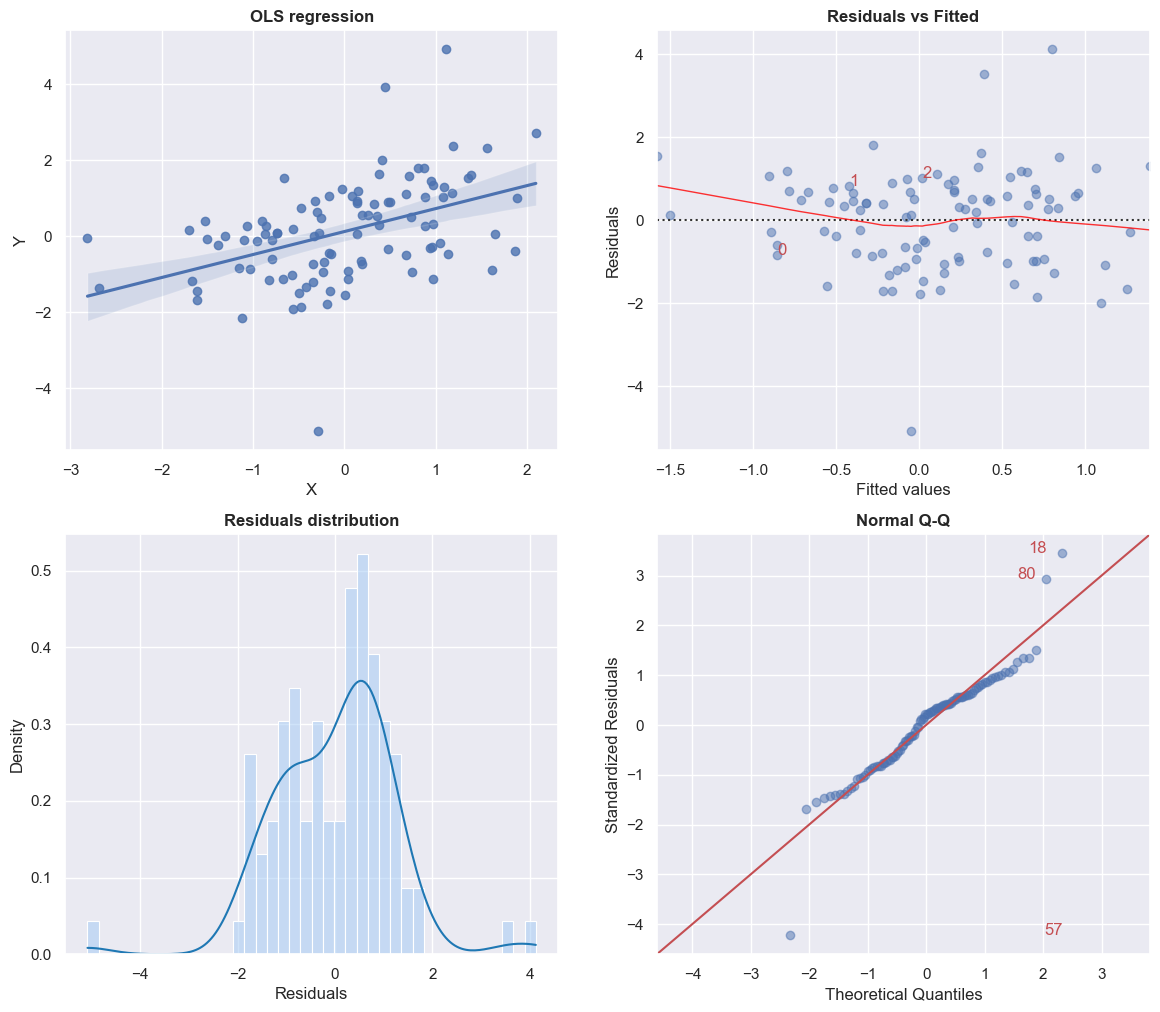

In [210]:
sns.set_theme()
# generate diagnostic plots class
cls = Linear_Reg_Diagnostic(res)

fig, ax = plt.subplots(2,2,figsize=(14, 12))

# Plot data and a OLS regression fit
sns.regplot(x="x", y="y", data=df,ax=ax[0][0])
ax[0][0].set_title('OLS regression', fontweight="bold")
ax[0][0].set_xlabel('X')
ax[0][0].set_ylabel('Y')

# plot the residual data point
cls.residual_plot(ax[0][1])

# plot the distribution of residuals
plot_resid(res).plot(ax[1][0],sns.color_palette("pastel")[0],sns.color_palette("Paired")[1])

# visually check if residuals are normally distributed
cls.qq_plot(ax=ax[1][1])

In [211]:
# Test whether a sample differs from a normal distribution
_, p = stats.normaltest(res.resid)
alpha=0.05

# null hypothesis: x comes from a normal distribution
if p<alpha:
    print("The null hypothesis can be rejected (p = {})".format(p))
else:
    print("The null hypothesis cannot be rejected")    

The null hypothesis can be rejected (p = 0.0008475313945909529)


### Question 2.2 & 2.3

In [212]:
# import package
# if you don't install those package, you need to use "pip install <package_name>" to get it
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import statsmodels.api as sm
import pandas as pd
import numpy as np
from statsmodels.base.model import GenericLikelihoodModel

In [213]:
# assume error term follows normal distribution whose mean is 0

# use MLE to do the regression
# using the norm distribution from scipy, we can write this likelihood simply as following
def _ll_norm(y, X, beta, sigma):
    resid=y-np.dot(X, beta)
    ll = norm.logpdf(resid, scale = sigma)
    return ll

# We create a new model class which inherits from GenericLikelihoodModel
class Normin(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        self.y=endog
        self.X=exog
        super().__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        '''This function should return one evaluation of the negative log-likelihood function per observation in your dataset '''
        sigma = params[-1]
        beta = params[:-1]
        ll = _ll_norm(self.endog, self.exog, beta, sigma)
        return -ll

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        ''' start_params: a one-dimensional array of starting values needs to be provided. 
            The size of this array determines the number of parameters that 
            will be used in optimization
        '''
        # we have one additional parameter and we need to add it for summary
        self.exog_names.append('sigma')
        if start_params == None:
            # Reasonable starting values
            start_params = np.append(np.zeros(self.exog.shape[1]), 1)
            # intercept
            start_params[-2] = np.log(self.endog.mean())
        self.res = super().fit(start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)
        return self.res

    def predict(self):
        '''calculate the fitted y and residuals'''
        y_pre=np.dot(self.X,self.res.params[:2])
        err=self.y-y_pre
        y_pre=pd.DataFrame(y_pre)
        err=pd.DataFrame(err)
        df=pd.concat([self.y,self.X.x,y_pre,err],axis=1)
        df.columns = ['y','x','y_pre','resid']
        return df 
    
    def R2(self):
        y_pre=np.dot(self.X,self.res.params[:2])
        SSE=sum((self.y-y_pre)**2)
        Mean=self.y.mean()
        SST=sum((self.y-Mean)**2)
        R2=1-SSE/SST

        n=self.y.shape[0]
        p=1
        adj_R2=1-(1-R2)*(n-1)/(n-p-1)
        return R2,adj_R2
        

In [214]:
# assume error term follows T distribution whose mean is 0

# use MLE to do the regression
# using the norm distribution from scipy, we can write this likelihood simply as following
def _ll_t(y, X, beta, df, sigma):
    resid=y-np.dot(X, beta)
    ll = t.logpdf(resid, df, scale=sigma)
    return ll
    
# We create a new model class which inherits from GenericLikelihoodModel
class Tin(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        self.y=endog
        self.X=exog
        super().__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        '''This function should return one evaluation of the negative log-likelihood function per observation in your dataset '''
        df = params[-2]
        sigma = params[-1]
        beta = params[:-2]
        ll = _ll_t(self.endog, self.exog, beta, df, sigma)
        return -ll

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        ''' start_params: a one-dimensional array of starting values needs to be provided. 
            The size of this array determines the number of parameters that 
            will be used in optimization
        '''
        
        # we have three additional parameters and we need to add it for summary
        self.exog_names.append('df')
        self.exog_names.append('sigma')
        if start_params == None:
            # Reasonable starting values
            start_params = np.append(np.zeros(self.exog.shape[1]), np.array([50,1]))
            # intercept
            start_params[-3] = np.log(self.endog.mean())
        self.res = super().fit(start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)
        return self.res

    def predict(self):
        '''calculate the fitted y and residuals'''
        y_pre=np.dot(self.X,self.res.params[:2])
        err=self.y-y_pre
        y_pre=pd.DataFrame(y_pre)
        err=pd.DataFrame(err)
        df=pd.concat([self.y,self.X.x,y_pre,err],axis=1)
        df.columns = ['y','x','y_pre','resid']
        return df

    def R2(self):
        y_pre=np.dot(self.X,self.res.params[:2])
        SSE=sum((self.y-y_pre)**2)
        Mean=self.y.mean()
        SST=sum((self.y-Mean)**2)
        R2=1-SSE/SST

        n=self.y.shape[0]
        p=1
        adj_R2=1-(1-R2)*(n-1)/(n-p-1)
        return R2,adj_R2

In [215]:
# read data from problem2.csv
df=pd.read_csv("problem2.csv")
y = df.y
X = df[['x']].copy()
X["constant"] = 1

In [216]:
# build the model calss
mod_norm = Normin(y, X)

# condcut fitting
res_norm = mod_norm.fit()

# get the parameters and corresponding p-value
print(res_norm.summary())

# calulate the R2, adjusted R2, AIC and BIC
R2_norm=mod_norm.R2()
print("R2 = {} \nadj_R2 = {}".format(R2_norm[0],R2_norm[1]))
print("AIC = {}".format(res_norm.aic))
print("BIC = {}".format(res_norm.bic))

Optimization terminated successfully.
         Current function value: 1.599921
         Iterations: 137
         Function evaluations: 243
                                Normin Results                                
Dep. Variable:                      y   Log-Likelihood:                -159.99
Model:                         Normin   AIC:                             324.0
Method:            Maximum Likelihood   BIC:                             329.2
Date:                Tue, 31 Jan 2023                                         
Time:                        01:20:14                                         
No. Observations:                 100                                         
Df Residuals:                      98                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

/Users/qijunyang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/qijunyang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


In [217]:
# build the model calss
mod_T = Tin(y, X)

# condcut fitting
res_T = mod_T.fit()

# get the parameters and corresponding p-value
print(res_T.summary())

# calulate the R2, adjusted R2, AIC and BIC
R2_T=mod_T.R2()
print("R2 = {} \nadj_R2 = {}".format(R2_T[0],R2_T[1]))
print("AIC = {}".format(res_T.aic))
print("BIC = {}".format(res_T.bic))

Optimization terminated successfully.
         Current function value: 1.554730
         Iterations: 370
         Function evaluations: 628
                                 Tin Results                                  
Dep. Variable:                      y   Log-Likelihood:                -155.47
Model:                            Tin   AIC:                             314.9
Method:            Maximum Likelihood   BIC:                             320.2
Date:                Tue, 31 Jan 2023                                         
Time:                        01:20:14                                         
No. Observations:                 100                                         
Df Residuals:                      98                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

/Users/qijunyang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/qijunyang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


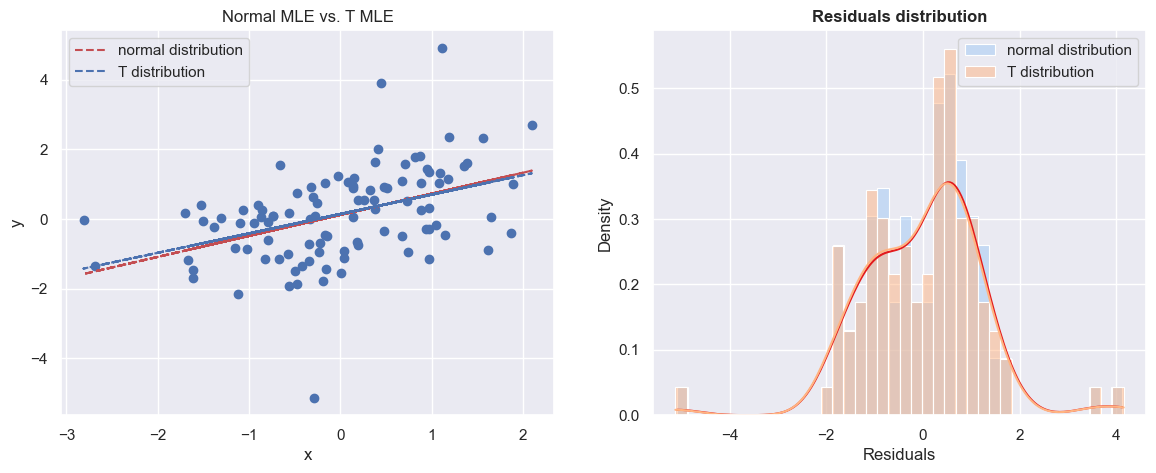

In [218]:
# plot the Normal MLE and T MLE and compare their difference
df_norm=mod_norm.predict()
df_T=mod_T.predict()

# intialize the plot setting
sns.set_theme()
fig, ax = plt.subplots(1,2,figsize=(14,5))

# plot the Normal MLE and T MLE
ax1=ax[0]
ax1.plot(df_norm.x, df_norm.y, 'bo')
ax1.plot(df_norm.x, df_norm.y_pre, 'r--', label="normal distribution")
ax1.plot(df_T.x, df_T.y_pre, 'b--', label="T distribution")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title("Normal MLE vs. T MLE")
ax1.legend(loc='best')

# plot the residuals from Normal MLE and T MLE
ax2=ax[1]
plot_resid(df_norm).plot(ax2,sns.color_palette("pastel")[0],sns.color_palette("Paired")[1],label="normal distribution")
plot_resid(df_T).plot(ax2,sns.color_palette("pastel")[1],sns.color_palette("Paired")[5],label="T distribution")
ax2.legend(loc='best')


# Question 3
Simulate AR(1) through AR(3) and MA(1) through MA(3) processes. Compare their ACF and PACF graphs. How do the graphs help us to identify the type and order of each process?

In [219]:
import statsmodels.api as sm
import numpy as np
from scipy import stats
import matplotlib.gridspec as gridspec

In [220]:
def simulate_AR1_process(alpha,beta,sigma,sample_size):
    ''' AR(1)
        y_t = alpha + beta*y_t-1 + e, e ~ N(0,sigma)
    '''
    x0=alpha/(1-beta)
    x=np.zeros(sample_size+1)
    x[0]=x0
    eps=stats.norm.rvs(size=sample_size,scale=sigma)
    for i in range(sample_size):
        x[i+1]=alpha+beta*x[i]+eps[i]
    return x

def simulate_AR2_process(alpha,beta,sigma,sample_size):
    ''' AR(2)
        y_t = alpha + beta[0]*y_t-1 + beta[1]*y_t-2 + e, e ~ N(0,sigma)
    '''
    x0=alpha/(1-sum(beta))
    eps=stats.norm.rvs(size=sample_size+1,scale=sigma)
    x=np.zeros(sample_size+2)
    x[0]=x0
    x[1]=x0+eps[0]
    for i in range(sample_size):
        x[i+2]=alpha+np.dot(beta,x[i:i+2])+eps[i+1]
    return x

def simulate_AR3_process(alpha,beta,sigma,sample_size):
    ''' AR(3)
        y_t = alpha + beta[0]*y_t-1 + beta[1]*y_t-2 + beta[2]*y_t-3 + e, e ~ N(0,sigma)
    '''
    x0=alpha/(1-sum(beta))
    eps=stats.norm.rvs(size=sample_size+2,scale=sigma)
    x=np.zeros(sample_size+3)
    x[0]=x0
    x[1]=x[0]+eps[0]
    x[2]=x[1]+eps[1]
    for i in range(sample_size):
        x[i+3]=alpha+np.dot(beta,x[i:i+3])+eps[i+2]
    return x

In [221]:
# generate sample for AR(1)
alpha = 0.75
beta = 0.4
sigma = 0.8
sample_size = 2000
ar1_sample=simulate_AR1_process(alpha,beta,sigma,sample_size)

# generate sample for AR(2)
alpha = 0.75
beta = np.array([0.4,0.3])
sigma = 0.8
sample_size = 2000
ar2_sample=simulate_AR2_process(alpha,beta,sigma,sample_size)

# generate sample for AR(3)
alpha = 0.75
beta = np.array([0.2,0.3,0.2])
sigma = 0.8
sample_size = 2000
ar3_sample=simulate_AR3_process(alpha,beta,sigma,sample_size)

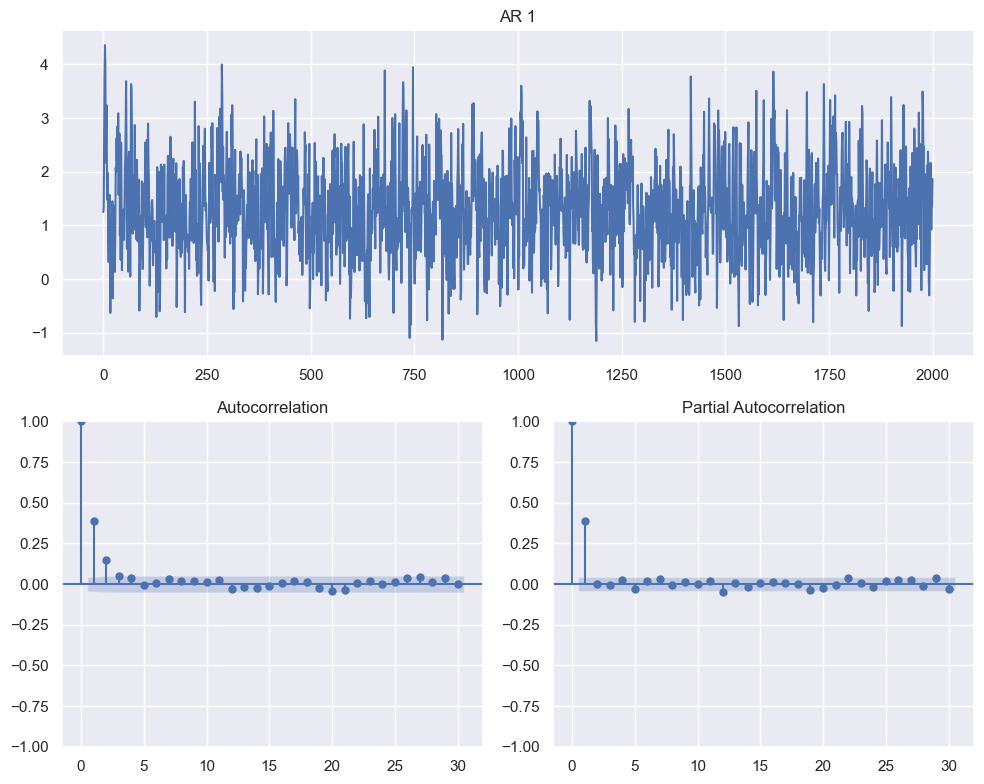

In [222]:
# plot for AR(1)
fig = plt.figure(tight_layout=True,figsize=[10,8])
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax.plot(ar1_sample)
ax.set_title("AR 1")

ax = fig.add_subplot(gs[1, 0])
sm.graphics.tsa.plot_acf(ar1_sample,ax=ax,lags=30)
ax = fig.add_subplot(gs[1, 1])
sm.graphics.tsa.plot_pacf(ar1_sample,method="ywm",ax=ax,lags=30)
plt.show()

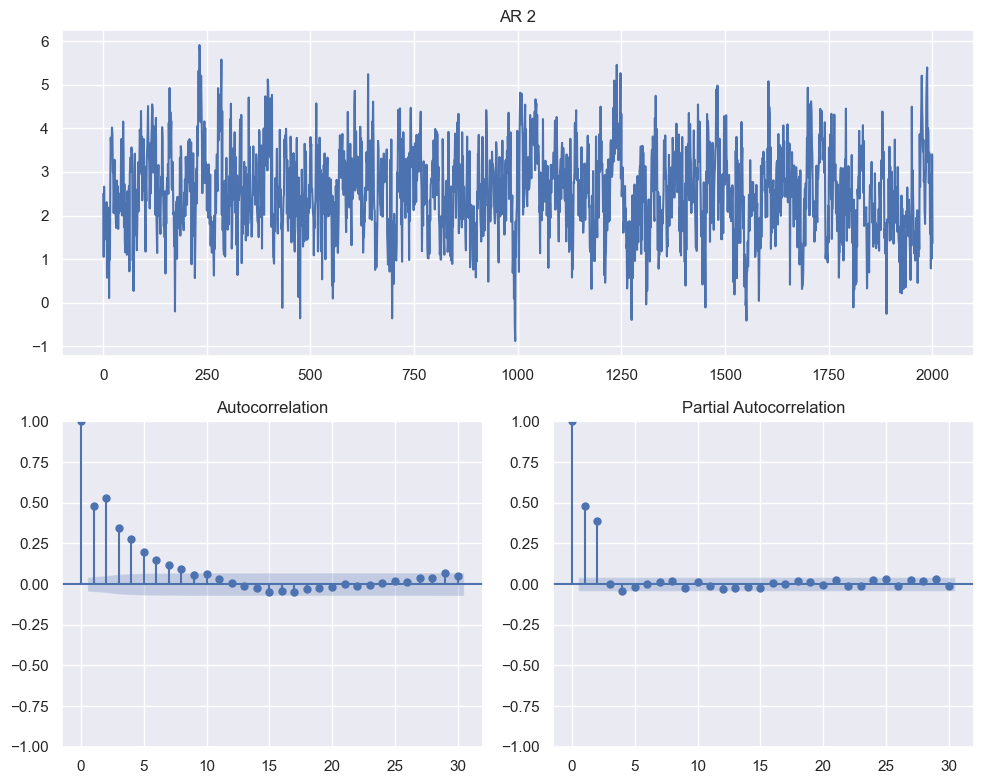

In [223]:
# plot for AR(2)
fig = plt.figure(tight_layout=True,figsize=[10,8])
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax.plot(ar2_sample)
ax.set_title("AR 2")

ax = fig.add_subplot(gs[1, 0])
sm.graphics.tsa.plot_acf(ar2_sample,ax=ax,lags=30)
ax = fig.add_subplot(gs[1, 1])
sm.graphics.tsa.plot_pacf(ar2_sample,method="ywm",ax=ax,lags=30)
plt.show()

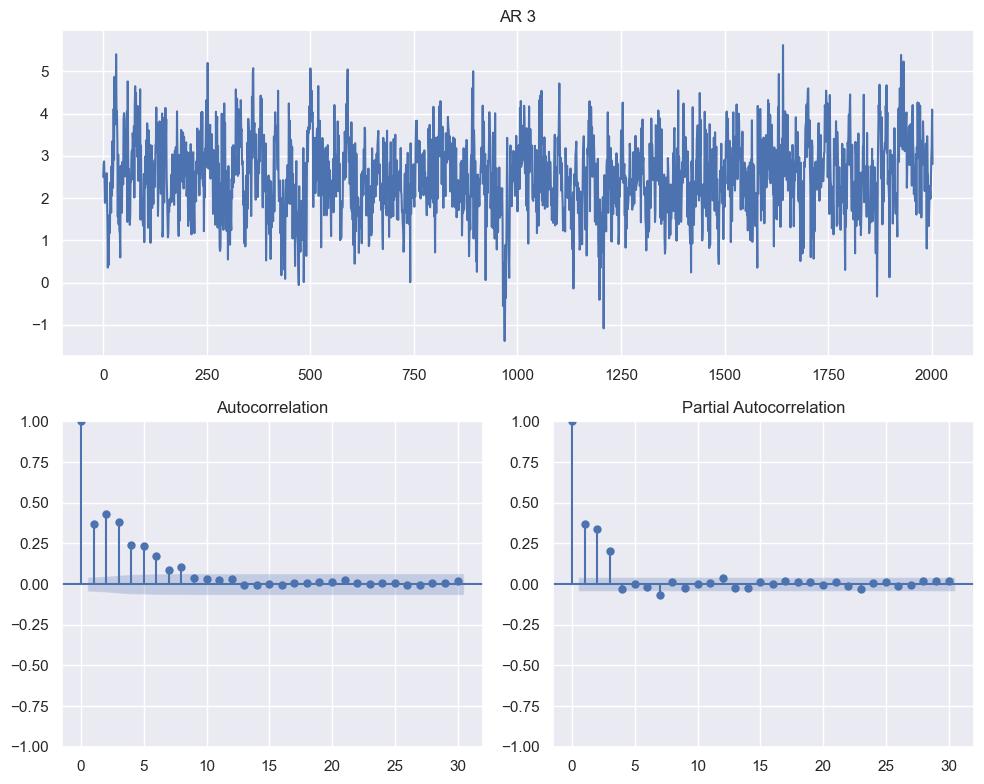

In [224]:
# plot for AR(3)
fig = plt.figure(tight_layout=True,figsize=[10,8])
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax.plot(ar3_sample)
ax.set_title("AR 3")

ax = fig.add_subplot(gs[1, 0])
sm.graphics.tsa.plot_acf(ar3_sample,ax=ax,lags=30)
ax = fig.add_subplot(gs[1, 1])
sm.graphics.tsa.plot_pacf(ar3_sample,method="ywm",ax=ax,lags=30)
plt.show()

In [225]:
def simulate_MA1_process(alpha,beta,sigma,sample_size):
    ''' MA(1)
        y_t = alpha + e_t + beta*e_t-1, e ~ N(0,sigma)
    '''
    x0=alpha
    x=np.zeros(sample_size+1)
    x[0]=x0
    eps=stats.norm.rvs(size=sample_size+1,scale=sigma)
    for i in range(sample_size):
        x[i+1]=alpha+eps[i+1]+beta*eps[i]
    return x

def simulate_MA2_process(alpha,beta,sigma,sample_size):
    ''' MA(2)
        y_t = alpha + e_t + beta[0]*e_t-1 + beta[1]*e_t-2, e ~ N(0,sigma)
    '''
    x0=alpha
    eps=stats.norm.rvs(size=sample_size+2,scale=sigma)
    x=np.zeros(sample_size+2)
    x[0]=x0
    x[1]=x0
    for i in range(sample_size):
        x[i+2]=alpha+eps[i+2]+np.dot(beta,eps[i:i+2][::-1])
    return x

def simulate_MA3_process(alpha,beta,sigma,sample_size):
    ''' MA(3)
        y_t = alpha + e_t + beta[0]*e_t-1 + beta[1]*e_t-2 + beta[2]*e_t-3, e ~ N(0,sigma)
    '''
    x0=alpha
    eps=stats.norm.rvs(size=sample_size+3,scale=sigma)
    x=np.zeros(sample_size+3)
    x[0]=x0
    x[1]=x[0]
    x[2]=x[0]
    for i in range(sample_size):
        x[i+3]=alpha+eps[i+3]+np.dot(beta,eps[i:i+3][::-1])
    return x

In [226]:
# generate sample for MA(1)
alpha = 0.75
beta = 0.4
sigma = 0.8
sample_size = 2000
ma1_sample=simulate_MA1_process(alpha,beta,sigma,sample_size)

# generate sample for MA(2)
alpha = 0.75
beta = np.array([0.4,0.3])
sigma = 0.8
sample_size = 2000
ma2_sample=simulate_MA2_process(alpha,beta,sigma,sample_size)

# generate sample for MA(3)
alpha = 0.75
beta = np.array([0.2,0.3,0.2])
sigma = 0.8
sample_size = 2000
ma3_sample=simulate_MA3_process(alpha,beta,sigma,sample_size)

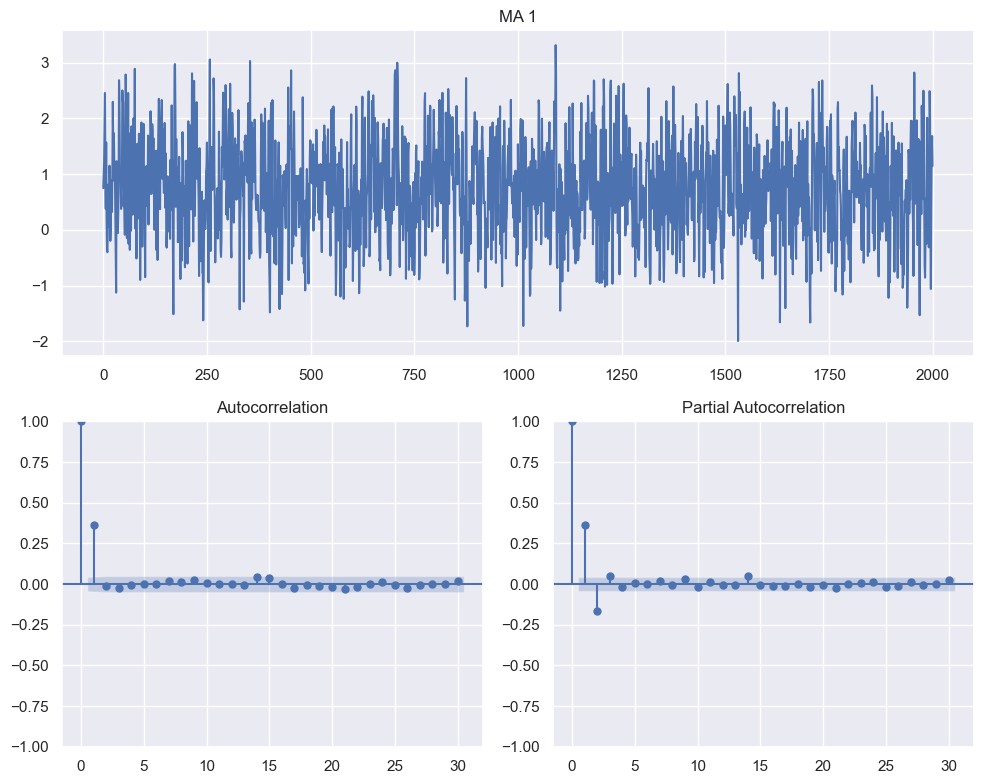

In [227]:
# plot for AR(1)
fig = plt.figure(tight_layout=True,figsize=[10,8])
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax.plot(ma1_sample)
ax.set_title("MA 1")

ax = fig.add_subplot(gs[1, 0])
sm.graphics.tsa.plot_acf(ma1_sample,ax=ax,lags=30)
ax = fig.add_subplot(gs[1, 1])
sm.graphics.tsa.plot_pacf(ma1_sample,method="ywm",ax=ax,lags=30)
plt.show()

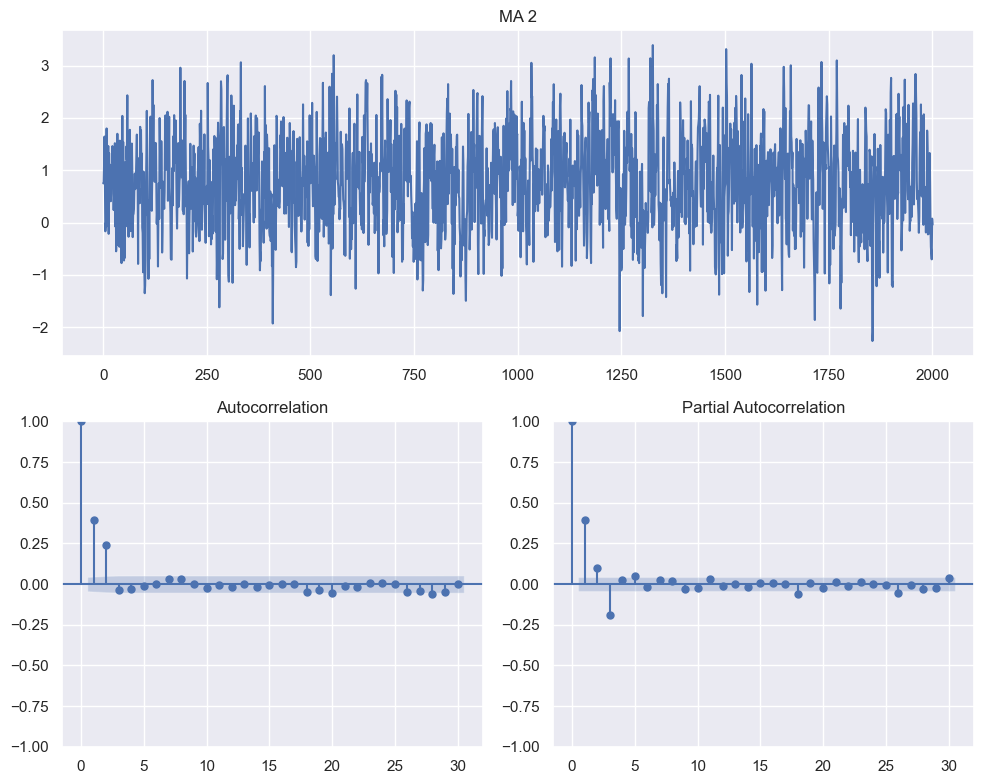

In [228]:
# plot for MA(2)
fig = plt.figure(tight_layout=True,figsize=[10,8])
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax.plot(ma2_sample)
ax.set_title("MA 2")

ax = fig.add_subplot(gs[1, 0])
sm.graphics.tsa.plot_acf(ma2_sample,ax=ax,lags=30)
ax = fig.add_subplot(gs[1, 1])
sm.graphics.tsa.plot_pacf(ma2_sample,method="ywm",ax=ax,lags=30)
plt.show()

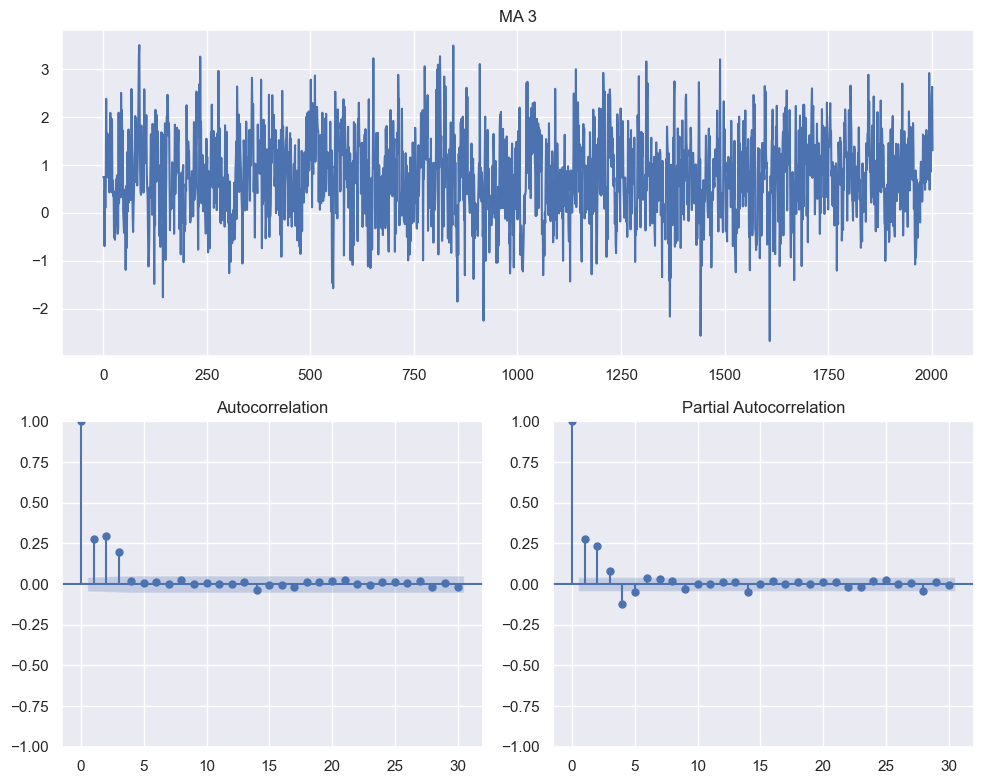

In [229]:
# plot for MA(3)
fig = plt.figure(tight_layout=True,figsize=[10,8])
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax.plot(ma3_sample)
ax.set_title("MA 3")

ax = fig.add_subplot(gs[1, 0])
sm.graphics.tsa.plot_acf(ma3_sample,ax=ax,lags=30)
ax = fig.add_subplot(gs[1, 1])
sm.graphics.tsa.plot_pacf(ma3_sample,method="ywm",ax=ax,lags=30)
plt.show()